In [34]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
PROCESSED_PATH = "../data/processed/"
TIME_COLUMN = 'timestamp'

df = pd.read_csv(os.path.join(PROCESSED_PATH, 'model_ready_dataset_5min.csv'),
                 parse_dates=[TIME_COLUMN]).set_index(TIME_COLUMN)


df = df.dropna()
df.head()

,RTM_CONG_PRC,RTM_ENE_PRC,RTM_LOSS_PRC,RTM_PRC,DAM_CONG_PRC,DAM_ENE_PRC,DAM_GHG_PRC,DAM_LOSS_PRC,DAM_PRC,2DA_LOAD,...,RTM_PRC_lag85min,RTM_PRC_lag90min,RTM_PRC_lag24hr,2DA_LOAD_lag1,RTPD_DMND_lag1,hour,dayofweek,month,is_weekend,is_night
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-02 14:00:00+00:00,0.0,213.26000,0.0,213.26000,0.0,151.1542,0.0,-2.32777,148.82643,8837.71,...,233.6136,216.0024,115.95011,8565.53,8490.66,6,0,1,False,False
2023-01-02 14:05:00+00:00,0.0,197.67000,0.0,197.67000,0.0,151.1542,0.0,-2.32777,148.82643,8715.03,...,213.2912,233.6136,115.95011,8837.71,8690.41,6,0,1,False,False
2023-01-02 14:10:00+00:00,0.0,195.06000,0.0,195.06000,0.0,151.1542,0.0,-2.32777,148.82643,8756.71,...,218.6124,213.2912,115.95011,8715.03,8690.41,6,0,1,False,False
2023-01-02 14:15:00+00:00,0.0,207.27322,0.0,207.27322,0.0,151.1542,0.0,-2.32777,148.82643,8789.51,...,218.1324,218.6124,115.95011,8756.71,8690.41,6,0,1,False,False
2023-01-02 14:20:00+00:00,0.0,244.96500,0.0,244.96500,0.0,151.1542,0.0,-2.32777,148.82643,8874.72,...,223.1912,218.1324,114.72000,8789.51,8789.51,6,0,1,False,False


In [36]:
# define structure for input and target
class DailySequenceDataset(Dataset):
    def __init__(self, input_data, target_data):
        """
        input_data: shape (num_days, seq_len, num_features)
        target_data: shape (num_days, seq_len)
        """
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        x = self.input_data[idx]
        y = self.target_data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
# Define the LSTM model
class DailyPricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(DailyPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out.squeeze(-1)


In [37]:
# Create derived features
df['RTM-DAM'] = df['RTM_PRC'] - df['DAM_PRC'] #difference between DAM and RTM, used as fitting target


In [38]:
# Define features and target
target = "RTM-DAM"
features = [
    "DAM_PRC",
    #"RTPD_PRC",
    "2DA_LOAD",
    #"2DA_LOAD_lag1",
    #"RTPD_DMND",
    #"RTPD_DMND_lag1",
    #'RTPD_Forecast_dmnd_diff',
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "is_night",
    #"RTM_PRC_lag75min",
    #"RTM_PRC_lag80min",
    #"RTM_PRC_lag85min",
    #"RTM_PRC_lag90min",
    "RTM_PRC_lag24hr",
]

In [39]:

# Helper function to prepare sequences from a long dataframe
def prepare_daily_sequences(df, feature_cols, target_col, samples_per_day=288):
    """
    df: time-indexed dataframe
    feature_cols: columns to use as features
    target_col: column to use as target
    """
    i1 = 0
    while True:
        if (df.index[i1].hour == 8) & (df.index[i1].minute == 0):
            break
        else:
            i1 += 1

    i2 = -1
    while True:
        if (df.index[i2].hour == 7) & (df.index[i2].minute == 55):
            break
        else:
            i2 -= 1

    df_ = df.iloc[i1:i2+1]
    
    features = []
    targets = []
    num_days = len(df) // samples_per_day

    for i in range(num_days - 1):
        day_start = i * samples_per_day
        day_end = (i + 1) * samples_per_day
        next_day_end = (i + 2) * samples_per_day

        x = df_.iloc[day_start:day_end][feature_cols].values
        y = df_.iloc[day_end:next_day_end][target_col].values

        if len(x) == samples_per_day and len(y) == samples_per_day:
            features.append(x)
            targets.append(y)

    return np.stack(features), np.stack(targets)


In [40]:
# Split into train/test and scale data

from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaled = pd.DataFrame(x_scaler.fit_transform(df[features]), columns=df[features].columns)
y_scaled = pd.DataFrame(y_scaler.fit_transform(df[[target]]), columns=df[[target]].columns)
x_scaled.index = df.index
y_scaled.index = df.index

df_scaled = x_scaled.join([y_scaled], how='outer')

train_size = int(len(df_scaled) * 0.8)

train_df = df_scaled.iloc[:train_size]
test_df = df_scaled.iloc[train_size:]

X_train, y_train = prepare_daily_sequences(train_df, features, target)
X_test, y_test = prepare_daily_sequences(test_df, features, target)

X_train = X_train.astype(float)
X_test = X_test.astype(float)



In [51]:
# Hyperparameters
input_size = len(features)           # Number of features per timestep
hidden_size = 64
batch_size = 16
num_epochs = 50
learning_rate = 0.001
#learning_rate = 0.001

# Load your actual data here
train_dataset = DailySequenceDataset(X_train, y_train)  # shape: (N, 288, input_size)
test_dataset = DailySequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = DailyPricePredictor(input_size=input_size, hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}")


Epoch 1/50, Train Loss: 1.0956, test Loss: 0.4820
Epoch 2/50, Train Loss: 1.0393, test Loss: 0.4615
Epoch 3/50, Train Loss: 1.0317, test Loss: 0.4618
Epoch 4/50, Train Loss: 0.9878, test Loss: 0.4615
Epoch 5/50, Train Loss: 0.9957, test Loss: 0.4662
Epoch 6/50, Train Loss: 0.9703, test Loss: 0.4695
Epoch 7/50, Train Loss: 0.9623, test Loss: 0.4762
Epoch 8/50, Train Loss: 0.9545, test Loss: 0.4734
Epoch 9/50, Train Loss: 0.9437, test Loss: 0.4631
Epoch 10/50, Train Loss: 0.9435, test Loss: 0.4582
Epoch 11/50, Train Loss: 0.9400, test Loss: 0.4651
Epoch 12/50, Train Loss: 0.9370, test Loss: 0.4650
Epoch 13/50, Train Loss: 0.9402, test Loss: 0.4702
Epoch 14/50, Train Loss: 0.9238, test Loss: 0.4593
Epoch 15/50, Train Loss: 0.9220, test Loss: 0.4668
Epoch 16/50, Train Loss: 0.9326, test Loss: 0.4561
Epoch 17/50, Train Loss: 0.9202, test Loss: 0.4653
Epoch 18/50, Train Loss: 0.9207, test Loss: 0.4705
Epoch 19/50, Train Loss: 0.9222, test Loss: 0.4624
Epoch 20/50, Train Loss: 0.9123, test Lo

In [52]:
def predict_day (offset_from_end):

    day_features = X_test[offset_from_end]
    
    # Reshape for batch dimension
    x_input = day_features[np.newaxis, :, :].astype('float32')  # shape: (1, 288, input_size)
    
    # Predict day's price deviation from DAM
    with torch.no_grad():
        x_tensor = torch.tensor(x_input, dtype=torch.float32)
        y_pred = model(x_tensor).numpy().flatten()

    y_act = y_test[offset_from_end]

    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_act = y_scaler.inverse_transform(y_act.reshape(-1, 1)).flatten()
    day_features = x_scaler.inverse_transform(day_features)
    
    return day_features, y_act, y_pred


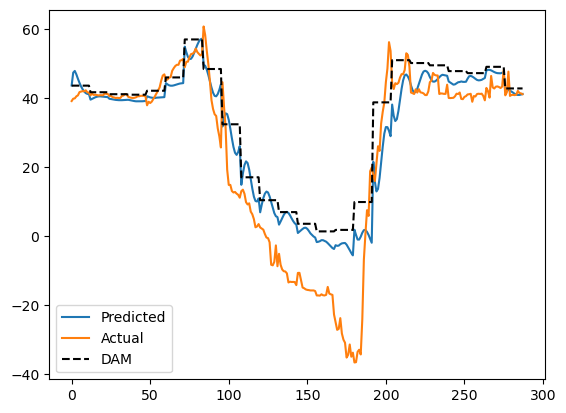

In [53]:
day_features, y_act, y_pred = predict_day(51)
dam = day_features[:,0]

plt.plot(y_pred + dam, label='Predicted')
plt.plot(y_act + dam, label='Actual')
plt.plot(dam, color='k', linestyle='--', label='DAM')
plt.legend()
#plt.plot(rtm)
#plt.plot(y_pred)